#**Assignment:**
**Multiclass classification model using a custom convolutional neural network in TensorFlow.**
###Submitted by: Koushik Goswami
## **Problem Statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

###Data feature & description:
The dataset consists of 2367 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.
The data set contains the following diseases: Actinic keratosis, Basal cell carcinoma, Dermatofibroma, Melanoma, Nevus, Pigmented benign keratosis, Seborrheic keratosis, Squamous cell carcinoma and Vascular lesion.



In [1]:
!pip install Augmentor

In [2]:
# Importing relevant libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import shutil
import Augmentor
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from collections import Counter

In [3]:
## Mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Defining the path for train and test datasets:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Skin Cancer Data/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin Cancer Data/Test')

###**Checking the image counts:**

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Train set image count:', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test set image count:', image_count_test)
print('Total image count:', image_count_train+image_count_test)

Train set image count: 2239
Test set image count: 118
Total image count: 2357


In [6]:
# Parameters
batch_size = 32
img_height = 180
img_width = 180

###**Create train and validation datasets from the original train dataset. Using 80% of the images as train data and 20% as validation**

In [9]:
seed = 123
# Function to create datasets
def create_datasets(data_dir, img_height, img_width, batch_size, validation_split=0.2, seed=123):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="training",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    return train_ds, val_ds

In [10]:
# Directory containing the images
data_dir = data_dir_train
# Create the training and validation datasets
train_ds, val_ds = create_datasets(data_dir, img_height, img_width, batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# Display the class names
class_names = train_ds.class_names
print("Class names:", class_names)

# Check a few batches of the training dataset
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

# Check a few batches of the validation dataset
for images, labels in val_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)
Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)


**Visualising one instance of image from each of the 9 class:**

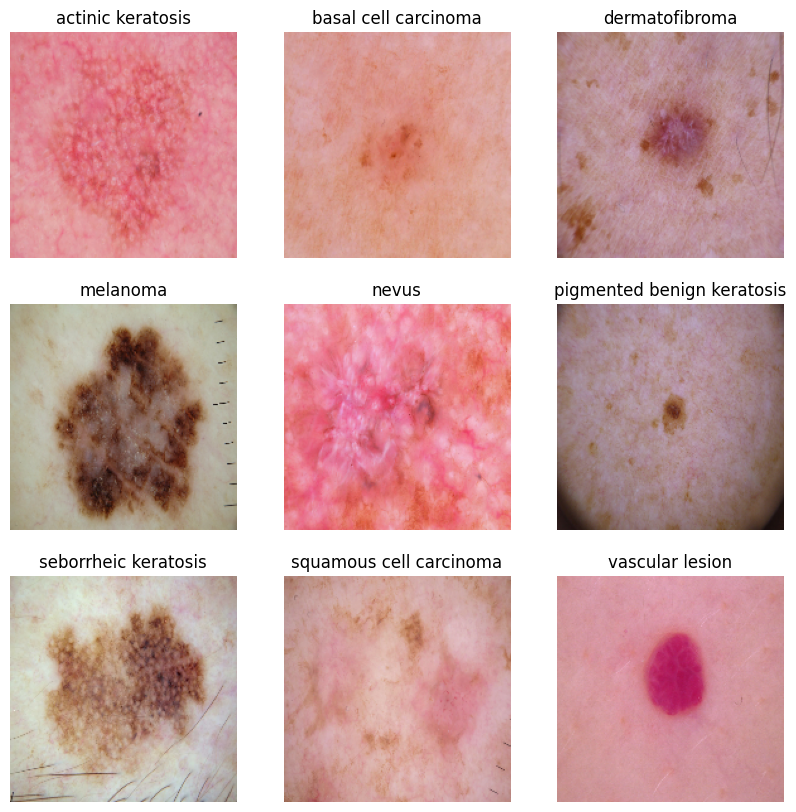

In [12]:
dataset = train_ds
# Create a dictionary to store one image per class
class_images = {class_name: None for class_name in class_names}

# Iterate through the dataset to extract one image per class
for images, labels in dataset:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_images[class_name] is None:
            class_images[class_name] = img
    # Check if we have one image for each class
    if None not in class_images.values():
        break

# Plotting the images
plt.figure(figsize=(10, 10))
for i, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

**Building the first model:**

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Define the CNN model
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(9, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 438s 743ms/step - loss: 2.1134 - accuracy: 0.2589 - val_loss: 1.6420 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.6031 - accuracy: 0.4425 - val_loss: 1.5298 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4684 - accuracy: 0.4827 - val_loss: 1.3999 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.3818 - accuracy: 0.5050 - val_loss: 1.4613 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2745 - accuracy: 0.5452 - val_loss: 1.4726 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2336 - accuracy: 0.5647 - val_loss: 1.3359 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 2s 35ms/step - loss: 1.1344 - accuracy: 0.5971 - val_loss: 1.4775 - val_accuracy: 0.5078
Epoch 8/20

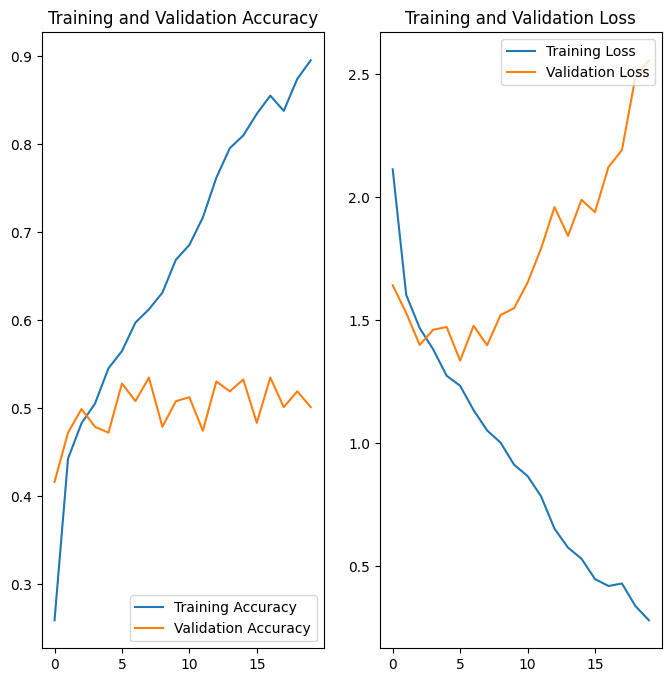

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**The model is not performing well. There is a marked difference between test accuracy and validation accuracy. This might be due to the model overfitting and issues with the data. However, the training accuracy is not very high so it may as well be interpreted as underfitting. Decrease and increase in number of layers and different sizes of convolution kernel, different values of dropouts are being applied and sizes of pooling windows are being varied. There is possibility that the data may not be uniform and so the same is being examined below.**

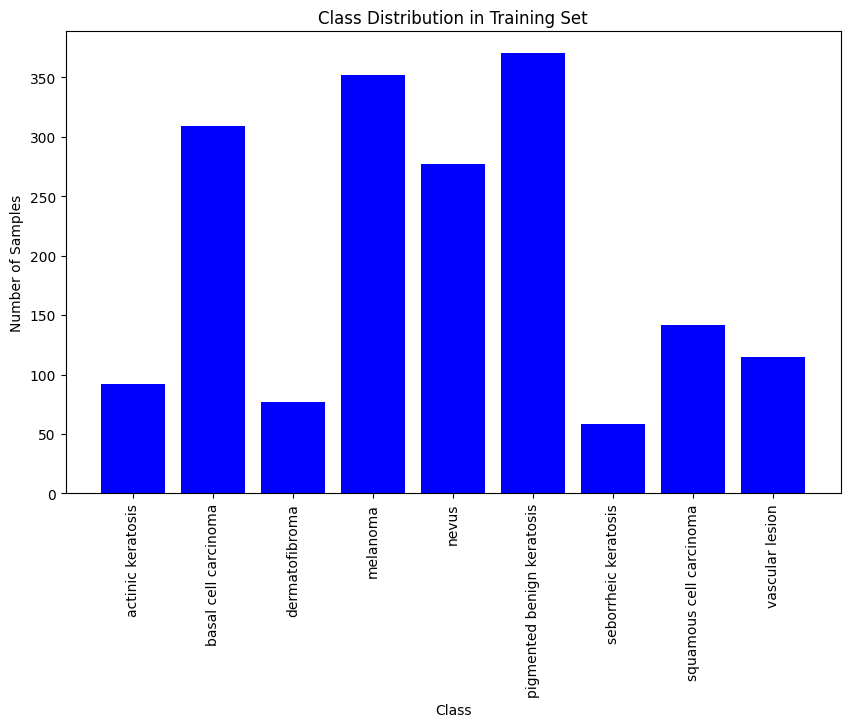

In [18]:
# Count samples per class
class_counts = Counter()

for images, labels in train_ds:
    class_counts.update(labels.numpy())

# Convert counts to a list in the order of class_names
class_counts_list = [class_counts[i] for i in range(len(class_names))]

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts_list, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=90)
plt.show()

In [19]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0     squamous cell carcinoma           181
1             vascular lesion           139
2  pigmented benign keratosis           462
3        seborrheic keratosis            77
4                       nevus           357
5                    melanoma           438
6              dermatofibroma            95
7        basal cell carcinoma           376
8           actinic keratosis           114

**From the above it is apparent that the data is not evenly distributed across the classes. Some classes are having more images and some are having very less. Classes melanoma and pigmented benign keratosis are having highest number of images while class seborrheic keratosis has least. As a solution to this, data augmentation is being resorted to. To begin with rotation of the images to create additional images will be tried.**

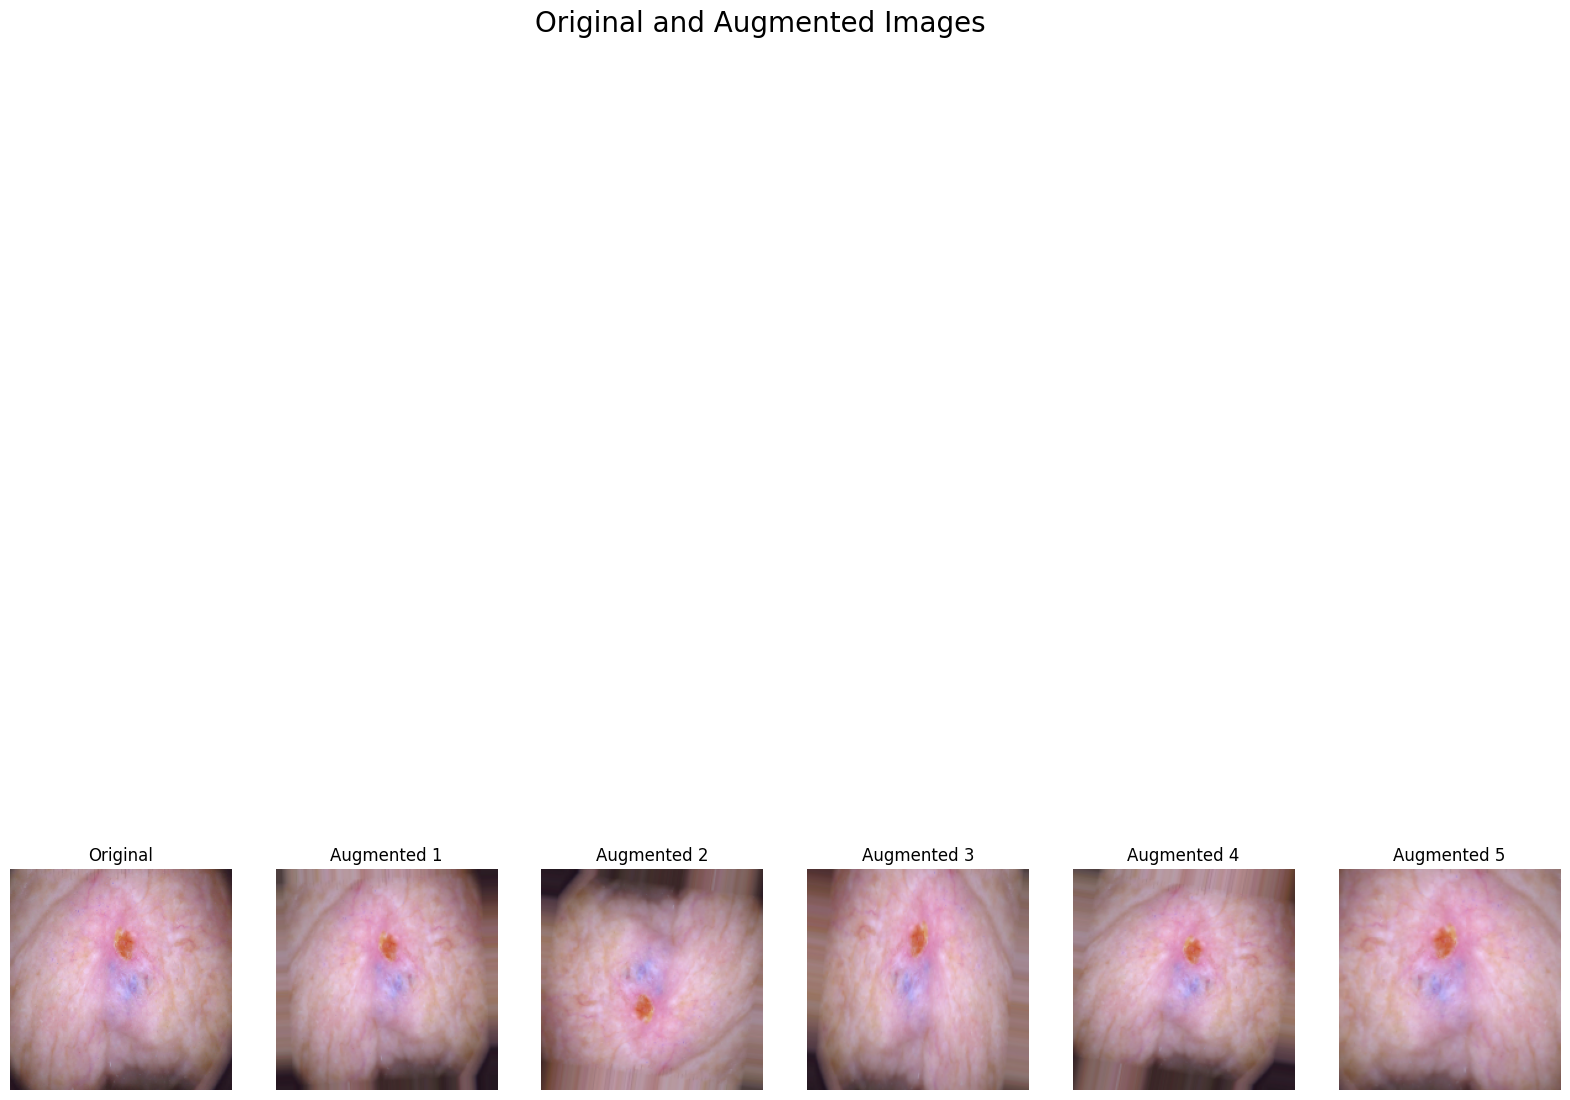

In [27]:
# Define the data augmentation strategy
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load one training image to visualize augmentation
train_images, train_labels = next(iter(train_ds))

# Select one image from the batch
sample_image = train_images[0]

# Reshape the image to (1, height, width, channels) for the data generator
sample_image = tf.expand_dims(sample_image, 0)

# Generate augmented images and visualize them
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
fig.suptitle('Original and Augmented Images', fontsize=20)

# Show the original image
axes[0].imshow(sample_image[0].numpy().astype("uint8"))
axes[0].set_title("Original")
axes[0].axis('off')

# Show augmented images
for i in range(1, 6):
    augmented_image = next(datagen.flow(sample_image, batch_size=1))
    axes[i].imshow(tf.squeeze(augmented_image).numpy().astype("uint8"))
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.show()

In [25]:
# Function to apply augmentation and move augmented images
def apply_augmentation(input_dir, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over class directories
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_dir) or class_name.startswith('.'):
            continue  # Skip if not a directory or is a hidden directory/file

        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Copy original images to the output directory
        for file_name in os.listdir(class_dir):
            full_file_name = os.path.join(class_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.copy(full_file_name, output_class_dir)

        # Create an Augmentor pipeline for each class directory
        p = Augmentor.Pipeline(class_dir, output_directory=output_class_dir)

        # Define augmentation operations
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.flip_left_right(probability=0.5)
        p.flip_top_bottom(probability=0.5)

        # Sample augmented images
        p.sample(500)  # Adjust the number of samples as needed
        print(f"Applied augmentation and moved images from '{class_dir}' to '{output_class_dir}'")

In [26]:
# Paths to input and output directories
input_dir = '/content/gdrive/MyDrive/Skin Cancer Data/Train'
output_dir = '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir'
os.makedirs(output_dir, exist_ok=True)

# Apply augmentation and move augmented images
apply_augmentation(input_dir, output_dir)

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBF5E159C30>: 100%|██████████| 500/500 [00:19<00:00, 25.37 Samples/s]


Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/squamous cell carcinoma' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/squamous cell carcinoma'
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBFB01D8910>: 100%|██████████| 500/500 [00:20<00:00, 24.24 Samples/s]


Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/vascular lesion' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/vascular lesion'
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBF556B0EE0>: 100%|██████████| 500/500 [00:22<00:00, 22.59 Samples/s]


Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/pigmented benign keratosis' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/pigmented benign keratosis'
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DBF52777250>: 100%|██████████| 500/500 [00:45<00:00, 10.99 Samples/s]


Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/seborrheic keratosis' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/seborrheic keratosis'
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/nevus.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7DBFB04F8070>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/nevus' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/nevus'
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DBFB03744C0>: 100%|██████████| 500/500 [01:34<00:00,  5.27 Samples/s]


Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/melanoma' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/melanoma'
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBF52633AC0>: 100%|██████████| 500/500 [00:20<00:00, 24.46 Samples/s]


Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/dermatofibroma' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/dermatofibroma'
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBFB02D8790>: 100%|██████████| 500/500 [00:20<00:00, 23.95 Samples/s]


Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/basal cell carcinoma' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/basal cell carcinoma'
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBF5578ADD0>: 100%|██████████| 500/500 [00:20<00:00, 23.94 Samples/s]

Applied augmentation and moved images from '/content/gdrive/MyDrive/Skin Cancer Data/Train/actinic keratosis' to '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir/actinic keratosis'


In [28]:
# Reload the augmented dataset
seed = 123
op_dir = '/content/gdrive/MyDrive/Skin Cancer Data/augmented_dir'
train_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
        op_dir,
        validation_split= 0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
        )
val_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
        op_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


###**Checking the augmented images across classes:**

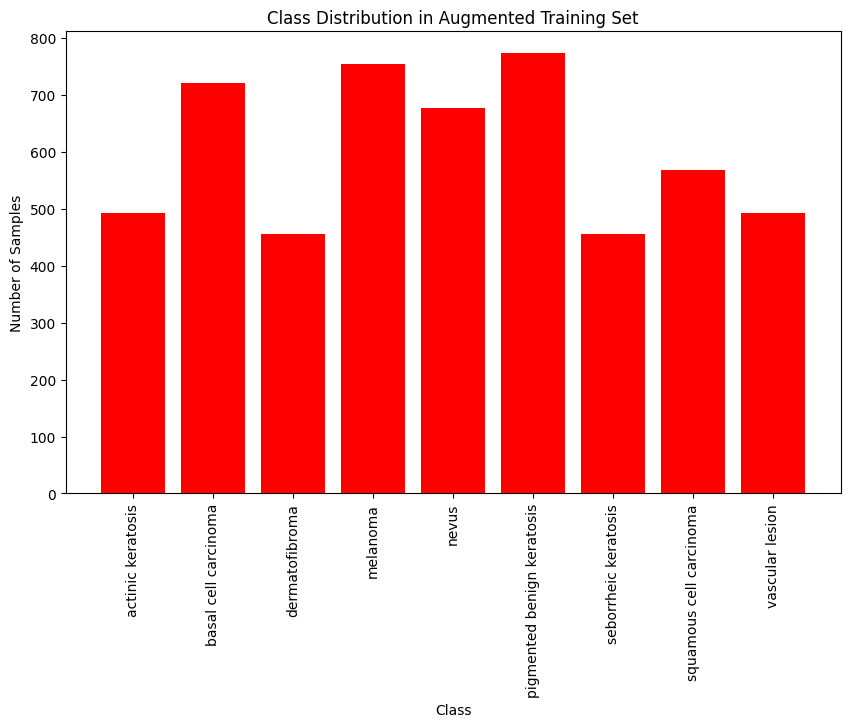

In [29]:
dataset = train_ds_augmented
class_names = train_ds_augmented.class_names
class_images = {class_name: None for class_name in class_names}
# Iterate through the dataset to extract one image per class
for images, labels in dataset:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_images[class_name] is None:
            class_images[class_name] = img
    # Check if we have one image for each class
    if None not in class_images.values():
        break

# Count samples per class in the augmented dataset
class_counts = Counter()
for images, labels in train_ds_augmented:
    class_counts.update(labels.numpy())

# Convert counts to a list in the order of class_names
class_counts_list = [class_counts[i] for i in range(len(class_names))]

# Plot class distribution after augmentation
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts_list, color='red')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Augmented Training Set')
plt.xticks(rotation=90)
plt.show()

In [37]:
#Rebuilding the model
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(9, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
aug_train_ds = train_ds_augmented.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
aug_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
# Compiling the model
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
# Train the model
epochs = 20
history = model.fit(
    aug_train_ds,
    validation_data=aug_val_ds,
    epochs=epochs,
)

Epoch 1/20
169/169 [==============================] - 38s 40ms/step - loss: 1.8328 - accuracy: 0.3142 - val_loss: 1.5601 - val_accuracy: 0.4832
Epoch 2/20
169/169 [==============================] - 6s 37ms/step - loss: 1.4890 - accuracy: 0.4279 - val_loss: 1.3622 - val_accuracy: 0.4653
Epoch 3/20
169/169 [==============================] - 6s 37ms/step - loss: 1.3839 - accuracy: 0.4711 - val_loss: 1.1718 - val_accuracy: 0.5817
Epoch 4/20
169/169 [==============================] - 6s 38ms/step - loss: 1.2943 - accuracy: 0.4918 - val_loss: 1.1372 - val_accuracy: 0.5459
Epoch 5/20
169/169 [==============================] - 6s 37ms/step - loss: 1.2044 - accuracy: 0.5408 - val_loss: 1.1918 - val_accuracy: 0.5839
Epoch 6/20
169/169 [==============================] - 6s 38ms/step - loss: 1.1458 - accuracy: 0.5642 - val_loss: 1.0698 - val_accuracy: 0.6309
Epoch 7/20
169/169 [==============================] - 6s 38ms/step - loss: 1.1379 - accuracy: 0.5644 - val_loss: 1.1465 - val_accuracy: 0.617

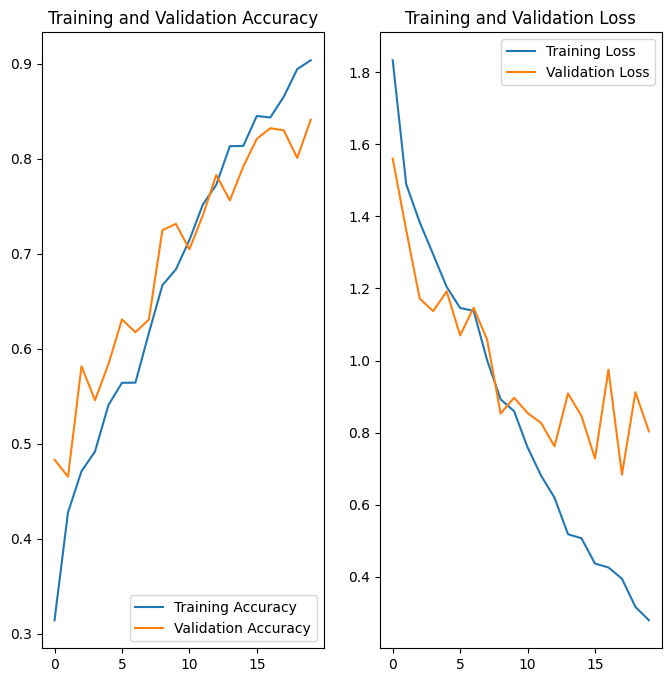

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**The model has improved but still, there is scope for further improvement. However due to computing resource constraint, the model is not being further refined and epochs was limited to 20 instead of 30. The model is being tested on the test set.**

In [44]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_test,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=32
)

Found 118 files belonging to 9 classes.


In [46]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

4/4 [==============================] - 4s 17ms/step - loss: 5.0911 - accuracy: 0.4153
Test Loss: 5.09110164642334
Test Accuracy: 0.41525423526763916


4/4 [==============================] - 5s 15ms/step
True Label: melanoma, Predicted Label: pigmented benign keratosis


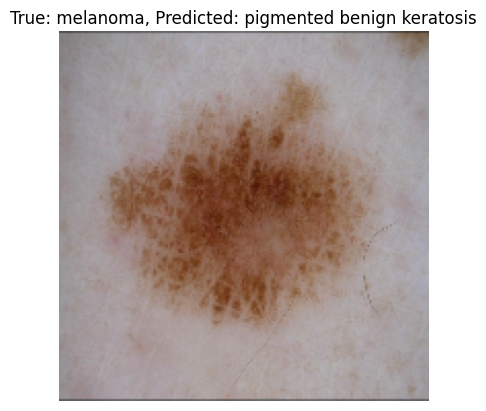

True Label: melanoma, Predicted Label: melanoma


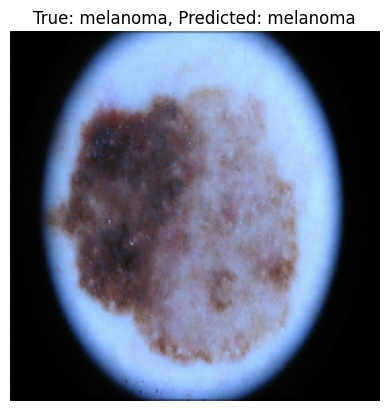

True Label: melanoma, Predicted Label: nevus


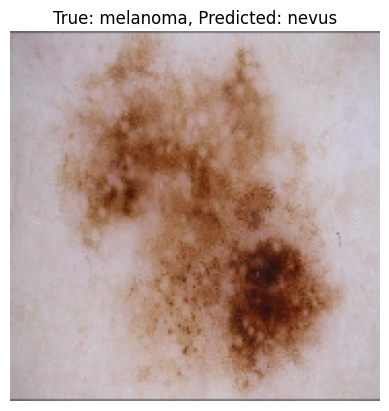

True Label: melanoma, Predicted Label: squamous cell carcinoma


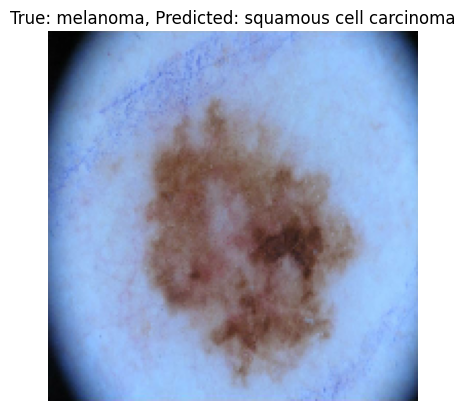

True Label: melanoma, Predicted Label: nevus


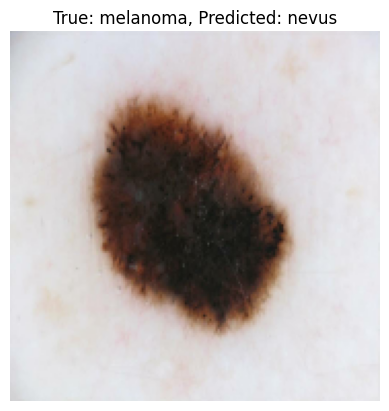

True Label: melanoma, Predicted Label: basal cell carcinoma


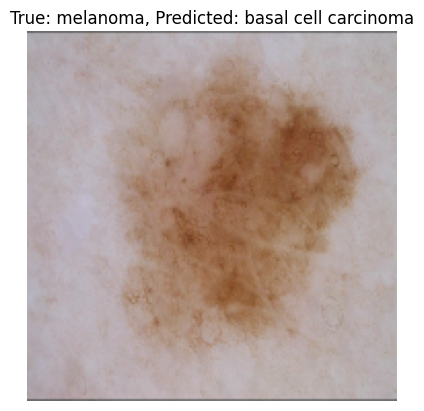

True Label: melanoma, Predicted Label: nevus


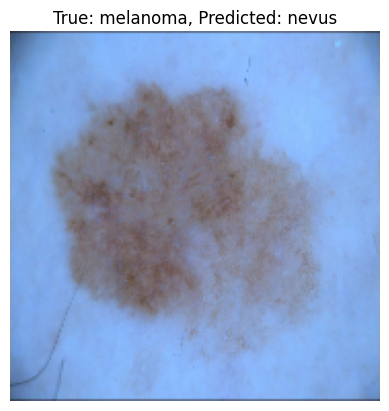

True Label: melanoma, Predicted Label: nevus


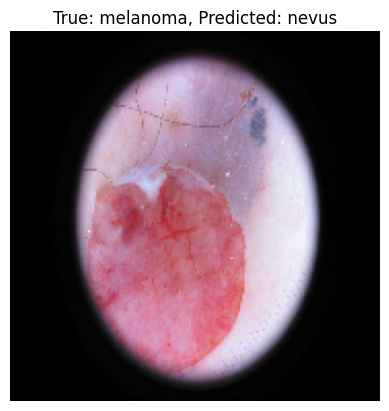

True Label: melanoma, Predicted Label: melanoma


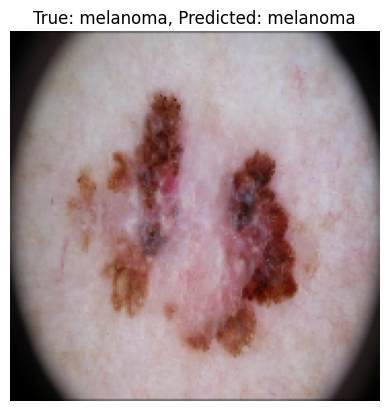

True Label: melanoma, Predicted Label: nevus


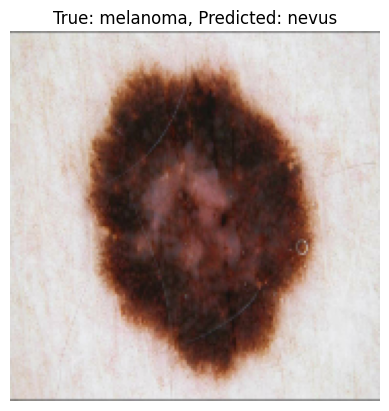

True Label: melanoma, Predicted Label: nevus


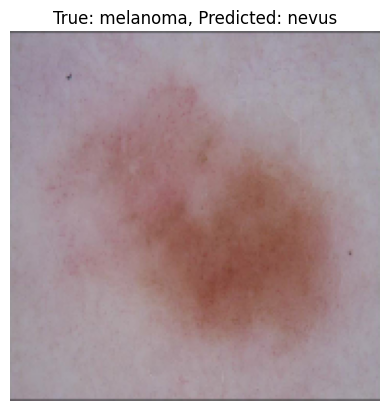

True Label: melanoma, Predicted Label: pigmented benign keratosis


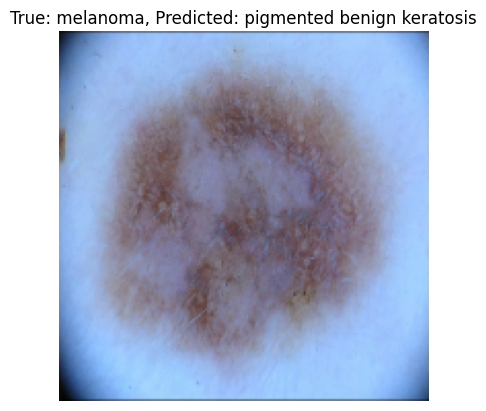

True Label: melanoma, Predicted Label: melanoma


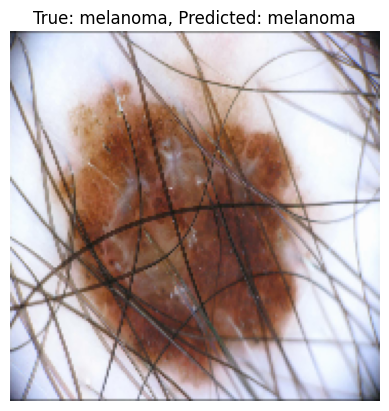

True Label: melanoma, Predicted Label: basal cell carcinoma


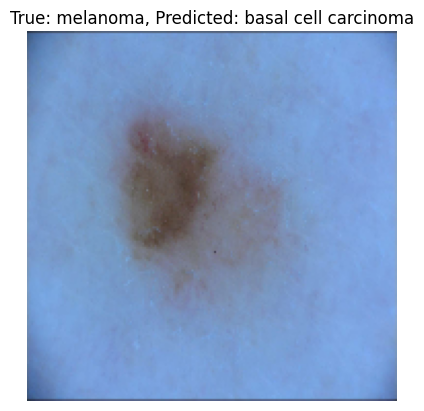

True Label: melanoma, Predicted Label: nevus


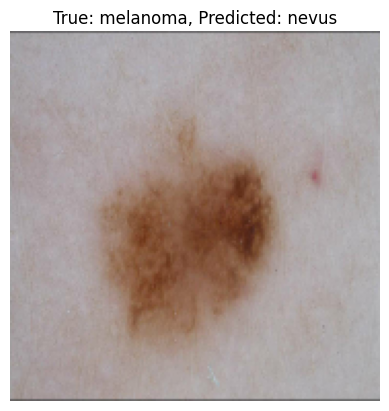

True Label: melanoma, Predicted Label: melanoma


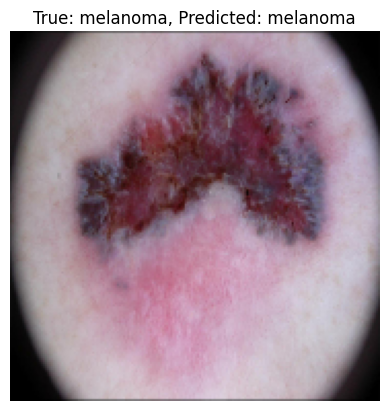

In [51]:
class_names = test_ds.class_names

# Make predictions
predictions = model.predict(test_ds)

# Display predictions for images labeled as 'melanoma'
melanoma_class_index = class_names.index('melanoma')

for images, labels in test_ds:
    for i in range(len(images)):
        img = images[i].numpy().astype("uint8")
        label = labels[i].numpy()

        if label == melanoma_class_index:
            predicted_label = np.argmax(predictions[i])
            print(f"True Label: {class_names[label]}, Predicted Label: {class_names[predicted_label]}")

            # Display the image
            plt.imshow(img)
            plt.title(f"True: {class_names[label]}, Predicted: {class_names[predicted_label]}")
            plt.axis('off')
            plt.show()

##The model requires further refinement.